# Review Sentiment Prediction

This is a binary classification problem where you need to predict whether the review sentiment is positive or negative

### Data Dictionary

 - **id**: Unique identifier for each tuple
 - **category**: The reviews have been categorized into two categories representing positive and negative reviews. 0 represents positive reviews and 1 represents negative reviews.
 - **text**: Tokenized text content of the review
 
### Evaluation Metric

 - Submissions are evaluated using [Precision_Score(Macro)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#:~:text=The%20precision%20is%20the%20ratio,the%20worst%20value%20is%200.)
 
 - e.g. ```precision_score(y_true, y_pred, average='macro')```

## 1. Import the packages

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample, shuffle

from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer, 
    HashingVectorizer, TfidfTransformer
)
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

## 2. Read the data

Read training data for building machine learning models

In [24]:
df = pd.read_csv('TRAIN.csv')
df.head()

,id,text,category
0,3973,1047 6700 4178 2912 183 6700,0
1,4462,4035 4563 1994 154 5373 4956 6035 4393 4017 40...,1
2,2889,5035 7685 3139 4407 254 584 6589 8518 3078,0
3,3457,1047 2540 2578 6700 2242 230 3771 4676 5881 64...,0
4,1555,7685 5868 237 6794 3078,0


Check the count of training data and observe data types of each features

In [25]:
df.shape

(2598, 3)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2598 entries, 0 to 2597
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2598 non-null   int64 
 1   text      2598 non-null   object
 2   category  2598 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 50.8+ KB


## 3. EDA

### 3.1 Observe class distribution

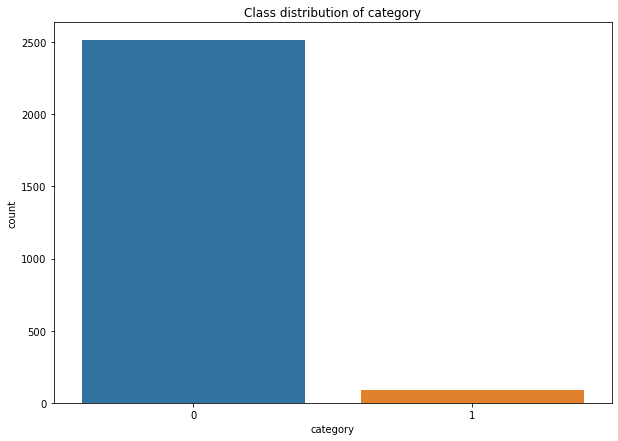

In [27]:
plt.figure(figsize=(10, 7))
plt.title('Class distribution of category')
sns.countplot(df['category'])
plt.show()

In [28]:
df['text'].head()

0                         1047 6700 4178 2912 183 6700
1    4035 4563 1994 154 5373 4956 6035 4393 4017 40...
2           5035 7685 3139 4407 254 584 6589 8518 3078
3    1047 2540 2578 6700 2242 230 3771 4676 5881 64...
4                              7685 5868 237 6794 3078
Name: text, dtype: object

### 3.2 Shuffle the data

In [7]:
# Shuffeling data
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,id,text,category
0,4408,590 724 5107 5121 4162 5773 187 5773 7087 8542...,0
1,2785,3919 5407 6084 6843 5071 2664 4032 634 3919 40...,0
2,3468,2610 230 8406 4450 7588 6700 4608 4799 5672 15...,0
3,3608,6084 6980 5551 8223 237 3225 4117 5773 5728 50...,0
4,1725,2734 2230 3160 8298 5335 230 226 5773 2977 586...,0


### 3.3 Split the data

In [108]:
train, test = train_test_split(df, test_size=0.10, stratify=df['category'], random_state=42)
print(train.shape, test.shape)

(2338, 3) (260, 3)


Try differenct vectorize methods to see the performance impact of each machine learning models

### 3.4 Trying Count Vectorizer:

In [109]:
cv = CountVectorizer(binary=True, min_df = 10, max_df = 0.95)
cv.fit_transform(train['text'].values)
X_train = cv.transform(train['text'].values)
X_test = cv.transform(test['text'].values)

print(X_train.shape, X_test.shape)

(2338, 575) (260, 575)


### 3.5 Trying TFIDF Vectorizer:

In [110]:
tfidf_v = TfidfVectorizer(use_idf=True, min_df=10, max_df=0.95)
tfidf_v.fit_transform(train['text'].values)
X_train = tfidf_v.transform(train['text'].values)
X_test = tfidf_v.transform(test['text'].values)

print(X_train.shape, X_test.shape)

(2338, 575) (260, 575)


### 3.6 Trying Hash Vectorizer:

In [11]:
hashv = HashingVectorizer(decode_error='ignore', alternate_sign=False)
hashv.fit_transform(train['text'].values)
X_train = hashv.transform(train['text'].values)
X_test = hashv.transform(test['text'].values)

print(X_train.shape, X_test.shape)

(2078, 1048576) (520, 1048576)


Separating target variables from train and test data

In [111]:
y_train = train['category'].values
y_test = test['category'].values

print(y_train.shape, y_test.shape)

(2338,) (260,)


## 4. Handle class imbalance

In [112]:
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# oversample = RandomOverSampler(sampling_strategy='minority')
# X_over, y_over = oversample.fit_resample(X_train, y_train)

# X_train, y_train = X_over, y_over

In [113]:
# Applying SMOTE
from imblearn.over_sampling import SMOTE

print('Shape of train dataset before applying SMOTE:', X_train.shape)

X_train, y_train = SMOTE().fit_resample(X_train, y_train)

print('Shape of train dataset after applying SMOTE:', X_train.shape)

Shape of train dataset before applying SMOTE: (2338, 575)
Shape of train dataset after applying SMOTE: (4522, 575)


## 5. Build and evaluate the baseline model

### 5.1. Logistic Regression

In [114]:
# Initialize the logistic regression model
lr = LogisticRegression() #LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)

# Fit the data
lr.fit(X_train, y_train)

# Find out the predictions
y_pred = lr.predict(X_test)

# Evaluate the precision score
print('Training precision score: ', precision_score(y_train, lr.predict(X_train), average='macro'))
print('Validation precision score: ', precision_score(y_test, y_pred, average='macro'))

Training precision score:  0.998237108858528
Validation precision score:  0.998015873015873


### 5.2. Random Forest Classifier

In [115]:
# Initialize the the model
rf = RandomForestClassifier(max_features=10, n_estimators=24, random_state=42)

# Fit the data
rf.fit(X_train, y_train)

# Find out the predictions
y_pred = rf.predict(X_test)

# Evaluate the precision score
print('Training precision score: ', precision_score(y_train, rf.predict(X_train), average='macro'))
print('Validation precision score: ', precision_score(y_test, y_pred, average='macro'))

Training precision score:  1.0
Validation precision score:  0.9960474308300395


### 5.3. XGBoost Classifier

In [116]:
# Initialize the the model
xgb = XGBClassifier(objective='binary:logistic')

# Fit the data
xgb.fit(X_train, y_train)

# Find out the predictions
y_pred = xgb.predict(X_test)

# Evaluate the precision score
print('Training precision score: ', precision_score(y_train, xgb.predict(X_train), average='macro'))
print('Validation precision score: ', precision_score(y_test, y_pred, average='macro'))

Training precision score:  0.9997789566755084
Validation precision score:  0.9960474308300395


### 5.4. SGD Classifier

In [117]:
# Initialize the the model
sgd = SGDClassifier()

# Fit the data
sgd.fit(X_train, y_train)

# Find out the predictions
y_pred = sgd.predict(X_test)

# Evaluate the precision score
print('Training precision score: ', precision_score(y_train, sgd.predict(X_train), average='macro'))
print('Validation precision score: ', precision_score(y_test, y_pred, average='macro'))

Training precision score:  0.9995581087052585
Validation precision score:  0.998015873015873


### 5.5. Linear SVC

In [118]:
from sklearn.svm import LinearSVC

# Initialize the the model
svc = LinearSVC(random_state=42, tol=1e-5)

# Fit the data
svc.fit(X_train, y_train)

# Find out the predictions
y_pred = svc.predict(X_test)

# Evaluate the precision score
print('Training precision score: ', precision_score(y_train, svc.predict(X_train), average='macro'))
print('Validation precision score: ', precision_score(y_test, y_pred, average='macro'))

Training precision score:  0.9995581087052585
Validation precision score:  0.998015873015873


### Best performing model

 - Here, we can see that Logistic Regression outperforms all other models with train and test **precision** score of 0.99.

## 6. Test and create submission file

In [119]:
df_test = pd.read_csv('TEST.csv')
df_test.head()

,id,text
0,1546,5222 7526 427 4829 7526 1164 4768 997 7924 332...
1,2956,590 983 5773 8352 1803 237 5045 6300 6267 5773...
2,4248,5915 4871 2982 6310 2734 3581 5773 6498 5773
3,4403,5435 1994 7248 1944 4017 3567 8618 5018 6619 3...
4,2097,6666 230 4768 2684 5773 3656 907 5922 2295 577...


In [120]:
df_test.shape

(866, 2)

In [121]:
#y_pred = xgb.predict(cv.transform(df_test['text'].values))
y_pred = lr.predict(tfidf_v.transform(df_test['text'].values))
#y_pred = lr.predict(hashv.transform(df_test['text'].values))

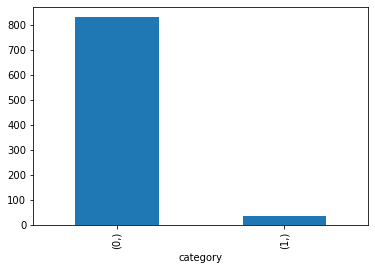

category
0           831
1            35
dtype: int64


In [122]:
Predicted_Y = pd.DataFrame(y_pred)
Predicted_Y.columns = ['category']

Predicted_Y.value_counts().plot.bar()
plt.show()
print(Predicted_Y.value_counts())

In [123]:
# Write Final preds
Predicted_Y.to_csv("./submission.csv", index=False)